In [1]:
# =========================================
# 0) 환경 준비 & Kaggle 데이터 다운로드
# =========================================
!pip install -q --upgrade kaggle
!pip install -q timm  # (선택) 일부 유틸 쓸 때 유용

import os, warnings
warnings.filterwarnings("ignore")

from google.colab import files
if not os.path.exists("/content/kaggle.json"):
    print("➡️ kaggle.json 업로드 창이 뜹니다. 파일을 선택해 주세요.")
    files.upload()  # kaggle.json

!mkdir -p ~/.kaggle /root/.config/kaggle
!cp kaggle.json ~/.kaggle/
!cp kaggle.json /root/.config/kaggle/
!chmod 600 ~/.kaggle/kaggle.json /root/.config/kaggle/kaggle.json

# State Farm 대회 데이터 다운로드/해제
!kaggle competitions download -c state-farm-distracted-driver-detection -q
!unzip -oq /content/state-farm-distracted-driver-detection.zip -d /content/statefarm_data

print("✅ 데이터 준비 완료")


✅ 데이터 준비 완료


In [2]:
# =========================================
# 1) 공통 임포트 & 경로/하이퍼파라미터
# =========================================
import os, sys, math, time, random
import numpy as np
import pandas as pd
from PIL import Image, ImageOps, ImageEnhance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import KFold
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Device:", device)
if device.type == "cuda":
    print("🧩 GPU:", torch.cuda.get_device_name(0))

# 데이터 경로
BASE_DIR      = "/content/statefarm_data"
DRIVER_CSV    = os.path.join(BASE_DIR, "driver_imgs_list.csv")
TRAIN_DIR     = os.path.join(BASE_DIR, "imgs", "train")
TEST_DIR      = os.path.join(BASE_DIR, "imgs", "test")

# 하이퍼파라미터
IMG_SIZE      = 224
NUM_CLASSES   = 10
BATCH_SIZE    = 64
EPOCHS        = 40
LR            = 5e-5            # GN 환경 권고: 시작 LR 낮춤
WEIGHT_DECAY  = 1e-4
NUM_WORKERS   = 2
PATIENCE      = 6               # EarlyStopping patience

# 1-Fold 설정 (KFold에서 0~4 중 하나 사용)
FOLD_INDEX    = 1

# 오프라인 공통 전처리 결과 캐시 폴더
OFFLINE_CACHE_DIR = "/content/statefarm_offline_cache"

driver_df = pd.read_csv(DRIVER_CSV)
ALL_DRIVERS = sorted(driver_df['subject'].unique())
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("👥 드라이버 수:", len(ALL_DRIVERS))
print("📄 CSV 존재:", os.path.exists(DRIVER_CSV))
print("📁 Train 폴더:", os.path.exists(TRAIN_DIR))
print("📁 Test  폴더:", os.path.exists(TEST_DIR))


🖥️ Device: cuda
🧩 GPU: Tesla T4
👥 드라이버 수: 26
📄 CSV 존재: True
📁 Train 폴더: True
📁 Test  폴더: True


In [3]:
# =========================================================
# 2) TEAM PROCESSING — OFFLINE(공통) / ONLINE(개인)
# =========================================================
# - OFFLINE: 결정적(deterministic) 처리 → 한 번만 디스크에 저장 (팀 공통 baseline)
# - ONLINE : 학습 중 배치마다 확률적(stochastic) 증강 적용 (개인/세션 차별화)

# ---- OFFLINE: 이미지 하나 처리 (결정적)
def team_processing_offline_pil(img_pil, out_size=IMG_SIZE):
    # 1) RGB 보장
    img = img_pil.convert("RGB")

    # 2) 리사이즈 (긴 변 기준 패딩 또는 간단 리사이즈 → 여기선 간단 리사이즈)
    img = img.resize((out_size, out_size), Image.BILINEAR)

    # 3) 가벼운 콘트라스트/샤프닝(결정적, 고정계수)
    img = ImageEnhance.Contrast(img).enhance(1.05)
    img = ImageEnhance.Sharpness(img).enhance(1.05)

    # 4) 히스토그램 평활화 (채널별 equalize)
    r, g, b = img.split()
    r, g, b = ImageOps.equalize(r), ImageOps.equalize(g), ImageOps.equalize(b)
    img = Image.merge("RGB", (r, g, b))

    return img

# ---- OFFLINE: 드라이버 서브셋을 캐시에 복제(+공통 전처리)
def build_offline_cache(train_dir, driver_df, driver_list, cache_root):
    for class_name in [f"c{i}" for i in range(NUM_CLASSES)]:
        os.makedirs(os.path.join(cache_root, class_name), exist_ok=True)

    subset = driver_df[driver_df['subject'].isin(driver_list)]
    pbar = tqdm(subset.itertuples(index=False), total=len(subset), desc="OFFLINE caching")
    for row in pbar:
        class_name, img_name = row.classname, row.img
        src = os.path.join(train_dir, class_name, img_name)
        dst = os.path.join(cache_root, class_name, img_name)
        if os.path.exists(dst):  # 이미 처리됨
            continue
        try:
            with Image.open(src) as im:
                out = team_processing_offline_pil(im, out_size=IMG_SIZE)
                out.save(dst, quality=95)
        except Exception as e:
            print("⚠️ OFFLINE 처리 실패:", src, e)

# ---- ONLINE: 학습 중 증강
normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std =[0.229, 0.224, 0.225])

transform_online_train = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10),
    transforms.RandomRotation(12),
    transforms.ToTensor(),
    normalize_imagenet
])

transform_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize_imagenet
])


In [4]:
# =========================================
# 3) Dataset (OFFLINE/ONLINE)
# =========================================
class DriverDataset(Dataset):
    def __init__(self, data_dir, driver_df, driver_list,
                 transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.is_test = is_test
        self.images, self.labels = [], []

        if is_test:
            for img_name in os.listdir(data_dir):
                if img_name.lower().endswith(('.jpg','.jpeg','.png')):
                    self.images.append(os.path.join(data_dir, img_name))
        else:
            sub = driver_df[driver_df['subject'].isin(driver_list)]
            for _, row in sub.iterrows():
                cls = row['classname']
                img = row['img']
                self.images.append(os.path.join(data_dir, cls, img))
                self.labels.append(int(cls[1:]))

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        if self.is_test:
            with Image.open(path) as im:
                im = im.convert("RGB")
                if self.transform: im = self.transform(im)
            return im, os.path.basename(path)
        else:
            with Image.open(path) as im:
                im = im.convert("RGB")
                if self.transform: im = self.transform(im)
            return im, self.labels[idx]


In [5]:
# =================================================================
# 4) Weight Standardization + GroupNorm (stage3~4에만 부분 적용)
# =================================================================
# Conv2dWS: forward 시 가중치 (필터별) 표준화
class Conv2dWS(nn.Conv2d):
    def forward(self, x):
        # [out_c, in_c, kH, kW] 가중치를 필터별로 표준화
        weight = self.weight
        weight_mean = weight.mean(dim=(1,2,3), keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1, keepdim=True).view(-1,1,1,1) + 1e-5
        weight = weight / std
        return nn.functional.conv2d(
            x, weight, self.bias, self.stride, self.padding, self.dilation, self.groups
        )

def replace_bn_with_gn(module, num_groups=32):
    for name, m in list(module.named_children()):
        # BatchNorm2d → GroupNorm
        if isinstance(m, nn.BatchNorm2d):
            gn = nn.GroupNorm(num_groups=num_groups, num_channels=m.num_features)
            setattr(module, name, gn)
        else:
            replace_bn_with_gn(m, num_groups=num_groups)

def replace_conv_with_ws(module):
    for name, m in list(module.named_children()):
        if isinstance(m, nn.Conv2d):
            # 동일 파라미터로 Conv2dWS 생성 후 치환
            ws = Conv2dWS(
                in_channels = m.in_channels,
                out_channels= m.out_channels,
                kernel_size = m.kernel_size,
                stride      = m.stride,
                padding     = m.padding,
                dilation    = m.dilation,
                groups      = m.groups,
                bias        = (m.bias is not None),
                padding_mode= m.padding_mode
            )
            # 기존 weight/bias 복사
            ws.weight.data.copy_(m.weight.data)
            if m.bias is not None:
                ws.bias.data.copy_(m.bias.data)
            setattr(module, name, ws)
        else:
            replace_conv_with_ws(m)

def build_resnet34_gn_ws(num_classes=NUM_CLASSES, pretrained=True):
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None)

    # fc 교체
    in_feat = model.fc.in_features
    model.fc = nn.Linear(in_feat, num_classes)

    # layer1,2는 BN/Conv 그대로(안정·속도)
    # layer3,4에만 GN + WS 적용
    replace_bn_with_gn(model.layer3, num_groups=32)
    replace_bn_with_gn(model.layer4, num_groups=32)
    replace_conv_with_ws(model.layer3)
    replace_conv_with_ws(model.layer4)

    # 학습 범위: layer1~2는 동결(특징 안정화), layer3~4 + fc만 학습
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    return model


In [6]:
# =========================================
# 5) 학습/검증 루프 + EarlyStopping
# =========================================
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct    += (out.argmax(1) == y).sum().item()
        total      += y.size(0)
    return total_loss/total, 100.0*correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, desc="Valid", leave=False):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item() * x.size(0)
        correct    += (out.argmax(1) == y).sum().item()
        total      += y.size(0)
    return total_loss/total, 100.0*correct/total

class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=True, delta=0.0):
        self.patience = patience
        self.verbose  = verbose
        self.delta    = delta
        self.best     = None
        self.count    = 0
        self.should_stop = False

    def step(self, metric, model=None, path=None):
        if self.best is None or (self.best - metric) > self.delta:
            self.best = metric
            self.count = 0
            if model is not None and path is not None:
                torch.save(model.state_dict(), path)
                if self.verbose:
                    print(f"✅ Best 갱신: {metric:.6f} → {path} 저장")
        else:
            self.count += 1
            if self.verbose:
                print(f"⏳ EarlyStopping 카운트: {self.count}/{self.patience}")
            if self.count >= self.patience:
                self.should_stop = True


In [7]:
# =========================================================
# 6) Fold 분할 → OFFLINE 캐시 생성 → DataLoader
# =========================================================
folds = list(kfold.split(ALL_DRIVERS))
train_idx, val_idx = folds[FOLD_INDEX]
train_drivers = [ALL_DRIVERS[i] for i in train_idx]
val_drivers   = [ALL_DRIVERS[i] for i in val_idx]

print(f"🎯 사용 Fold: {FOLD_INDEX} / Train drivers={len(train_drivers)}, Val drivers={len(val_drivers)}")

# 1) OFFLINE 캐시(팀 공통) 생성 — 학습·검증 모두에 동일 처리
os.makedirs(OFFLINE_CACHE_DIR, exist_ok=True)
build_offline_cache(TRAIN_DIR, driver_df, train_drivers, OFFLINE_CACHE_DIR)
build_offline_cache(TRAIN_DIR, driver_df, val_drivers,   OFFLINE_CACHE_DIR)

# 2) Dataset & Loader
#    - 학습: ONLINE 변환(개인/세션 증강) + OFFLINE 캐시를 데이터 소스로 사용
#    - 검증: 결정적 eval 변환
train_ds = DriverDataset(OFFLINE_CACHE_DIR, driver_df, train_drivers, transform=transform_online_train)
val_ds   = DriverDataset(OFFLINE_CACHE_DIR, driver_df, val_drivers,   transform=transform_eval)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("🧺 배치 수 | Train:", math.ceil(len(train_ds)/BATCH_SIZE), "| Val:", math.ceil(len(val_ds)/BATCH_SIZE))


🎯 사용 Fold: 1 / Train drivers=21, Val drivers=5


OFFLINE caching: 100%|██████████| 4006/4006 [00:00<00:00, 70730.79it/s]


🧺 배치 수 | Train: 288 | Val: 63


In [8]:
# =========================================
# 7) 모델 생성 + 옵티마이저
# =========================================
model = build_resnet34_gn_ws(num_classes=NUM_CLASSES, pretrained=True).to(device)

# 학습 가능한 파라미터만 옵티마이저에 전달 (layer1/2 동결됨)
optim_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(optim_params, lr=LR, weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()

# (선택) 코사인 스케줄러 + 간단 워ーム업
warmup_epochs = 3
total_epochs  = EPOCHS
def lr_lambda(current_epoch):
    if current_epoch < warmup_epochs:
        return float(current_epoch + 1) / float(max(1, warmup_epochs))
    # warmup 이후 코사인
    progress = (current_epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

print("🔧 학습 파라미터 수:", sum(p.numel() for p in optim_params))


🔧 학습 파라미터 수: 19951434


In [9]:
# =========================================
# 8) 학습 실행 (40epoch + EarlyStopping)
# =========================================
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_model_path = f"/content/resnet34_gnws_fold{FOLD_INDEX}_best.pth"
es = EarlyStopping(patience=PATIENCE, verbose=True)

for epoch in range(EPOCHS):
    print(f"\n🔵 Epoch {epoch+1}/{EPOCHS} | lr={optimizer.param_groups[0]['lr']:.6f}")

    t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    v_loss, v_acc = evaluate(model, val_loader, criterion)

    history["train_loss"].append(t_loss); history["train_acc"].append(t_acc)
    history["val_loss"].append(v_loss);   history["val_acc"].append(v_acc)

    print(f"  👉 Train  : loss={t_loss:.4f}, acc={t_acc:.2f}%")
    print(f"  👉 Val    : loss={v_loss:.4f}, acc={v_acc:.2f}%")

    # 체크포인트(5ep 간격 임시 저장)
    if (epoch+1) % 5 == 0:
        tmp = f"/content/resnet34_gnws_fold{FOLD_INDEX}_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), tmp)
        print(f"  💾 Temp save @ {tmp}")

    # EarlyStopping(val_loss) + best 저장
    es.step(v_loss, model=model, path=best_model_path)
    if es.should_stop:
        print("🛑 Early stopping 트리거")
        break

    scheduler.step()

final_model_path = f"/content/resnet34_gnws_fold{FOLD_INDEX}_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"\n🏁 학습 종료 | 최종 저장: {final_model_path}")

# 학습 이력 저장
hist_df = pd.DataFrame(history)
hist_csv = f"/content/resnet34_gnws_fold{FOLD_INDEX}_history.csv"
hist_df.to_csv(hist_csv, index=False)
print("📈 이력 CSV:", hist_csv)
hist_df.tail()



🔵 Epoch 1/40 | lr=0.000017


  👉 Train  : loss=0.7478, acc=78.94%
  👉 Val    : loss=0.7926, acc=72.82%
✅ Best 갱신: 0.792616 → /content/resnet34_gnws_fold1_best.pth 저장

🔵 Epoch 2/40 | lr=0.000033


  👉 Train  : loss=0.1263, acc=96.56%
  👉 Val    : loss=0.7966, acc=77.53%
⏳ EarlyStopping 카운트: 1/6

🔵 Epoch 3/40 | lr=0.000050


  👉 Train  : loss=0.0793, acc=97.58%
  👉 Val    : loss=0.9143, acc=76.83%
⏳ EarlyStopping 카운트: 2/6

🔵 Epoch 4/40 | lr=0.000050


  👉 Train  : loss=0.0482, acc=98.62%
  👉 Val    : loss=0.7927, acc=78.03%
⏳ EarlyStopping 카운트: 3/6

🔵 Epoch 5/40 | lr=0.000050


  👉 Train  : loss=0.0315, acc=99.09%
  👉 Val    : loss=1.0054, acc=78.43%
  💾 Temp save @ /content/resnet34_gnws_fold1_epoch5.pth
⏳ EarlyStopping 카운트: 4/6

🔵 Epoch 6/40 | lr=0.000050


  👉 Train  : loss=0.0336, acc=98.98%
  👉 Val    : loss=0.7485, acc=79.36%
✅ Best 갱신: 0.748486 → /content/resnet34_gnws_fold1_best.pth 저장

🔵 Epoch 7/40 | lr=0.000049


  👉 Train  : loss=0.0251, acc=99.23%
  👉 Val    : loss=1.1411, acc=76.09%
⏳ EarlyStopping 카운트: 1/6

🔵 Epoch 8/40 | lr=0.000049


  👉 Train  : loss=0.0153, acc=99.56%
  👉 Val    : loss=1.4039, acc=75.96%
⏳ EarlyStopping 카운트: 2/6

🔵 Epoch 9/40 | lr=0.000048


  👉 Train  : loss=0.0171, acc=99.52%
  👉 Val    : loss=1.1920, acc=77.96%
⏳ EarlyStopping 카운트: 3/6

🔵 Epoch 10/40 | lr=0.000047


  👉 Train  : loss=0.0173, acc=99.54%
  👉 Val    : loss=1.2662, acc=75.06%
  💾 Temp save @ /content/resnet34_gnws_fold1_epoch10.pth
⏳ EarlyStopping 카운트: 4/6

🔵 Epoch 11/40 | lr=0.000046


  👉 Train  : loss=0.0223, acc=99.24%
  👉 Val    : loss=1.0518, acc=77.91%
⏳ EarlyStopping 카운트: 5/6

🔵 Epoch 12/40 | lr=0.000044


  👉 Train  : loss=0.0174, acc=99.46%
  👉 Val    : loss=1.2232, acc=75.94%
⏳ EarlyStopping 카운트: 6/6
🛑 Early stopping 트리거

🏁 학습 종료 | 최종 저장: /content/resnet34_gnws_fold1_final.pth
📈 이력 CSV: /content/resnet34_gnws_fold1_history.csv


,train_loss,train_acc,val_loss,val_acc
7,0.015279,99.560213,1.403929,75.961058
8,0.017104,99.522207,1.191961,77.958063
9,0.017322,99.538495,1.266241,75.062406
10,0.022274,99.239874,1.051815,77.908138
11,0.017385,99.457053,1.223205,75.936096


In [10]:
# =========================================
# 9) 테스트 추론 & 제출 파일
# =========================================
# 테스트는 OFFLINE 캐시가 없으므로 원본 TEST_DIR 기반
test_transform = transform_eval

# 베스트 모델 로드
best_path = best_model_path if os.path.exists(best_model_path) else final_model_path
print("🔁 로드 모델:", best_path)
infer_model = build_resnet34_gn_ws(num_classes=NUM_CLASSES, pretrained=False).to(device)
infer_model.load_state_dict(torch.load(best_path, map_location=device))
infer_model.eval()

# 테스트 로더
test_imgs = [f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))]
test_imgs.sort()
class TestSet(torch.utils.data.Dataset):
    def __len__(self): return len(test_imgs)
    def __getitem__(self, i):
        path = os.path.join(TEST_DIR, test_imgs[i])
        with Image.open(path) as im:
            im = im.convert("RGB")
            im = test_transform(im)
        return im, os.path.basename(path)

test_loader = DataLoader(TestSet(), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# 예측
preds, names = [], []
with torch.no_grad():
    for x, fn in tqdm(test_loader, desc="Predict"):
        x = x.to(device)
        out = infer_model(x)
        prob = torch.softmax(out, dim=1).cpu().numpy()
        preds.append(prob); names.extend(list(fn))

preds = np.vstack(preds)
cols  = [f"c{i}" for i in range(NUM_CLASSES)]
sub   = pd.DataFrame(preds, columns=cols)
sub.insert(0, "img", names)

SUBMIT_CSV = f"/content/resnet34_gnws_fold{FOLD_INDEX}_submission.csv"
sub.to_csv(SUBMIT_CSV, index=False)
print("✅ 제출 파일:", SUBMIT_CSV)
sub.head()


🔁 로드 모델: /content/resnet34_gnws_fold1_best.pth


Predict: 100%|██████████| 1246/1246 [06:31<00:00,  3.18it/s]


✅ 제출 파일: /content/resnet34_gnws_fold1_submission.csv


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.000081,0.000117,0.000233,0.000206,0.000032,0.999014,0.000110,0.000020,0.000145,0.000042
1,img_10.jpg,0.001089,0.000027,0.000026,0.000074,0.000040,0.998198,0.000077,0.000053,0.000371,0.000045
2,img_100.jpg,0.849664,0.004101,0.000529,0.011703,0.000912,0.000855,0.000441,0.007563,0.103792,0.020439
3,img_1000.jpg,0.000124,0.000116,0.013908,0.000021,0.000076,0.000047,0.000178,0.000050,0.985447,0.000032
4,img_100000.jpg,0.000071,0.000487,0.000078,0.997588,0.000298,0.000187,0.000181,0.000032,0.000666,0.000414


In [11]:
# =========================================
# 10) CSV 자동 다운로드 (런타임 종료 대비)
# =========================================
from google.colab import files
import time

# 최종 제출 CSV 경로 (앞 단계 SUBMIT_CSV 변수 재사용)
try:
    print(f"📦 자동 다운로드 시작: {SUBMIT_CSV}")
    # 파일 존재 확인 (딜레이 보정)
    for i in range(10):
        if os.path.exists(SUBMIT_CSV):
            break
        print("⏳ CSV 생성 대기중...")
        time.sleep(5)

    # 실제 다운로드
    files.download(SUBMIT_CSV)
    print("✅ CSV 자동 다운로드 완료!")
except Exception as e:
    print("⚠️ 다운로드 중 오류 발생:", e)


📦 자동 다운로드 시작: /content/resnet34_gnws_fold1_submission.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ CSV 자동 다운로드 완료!


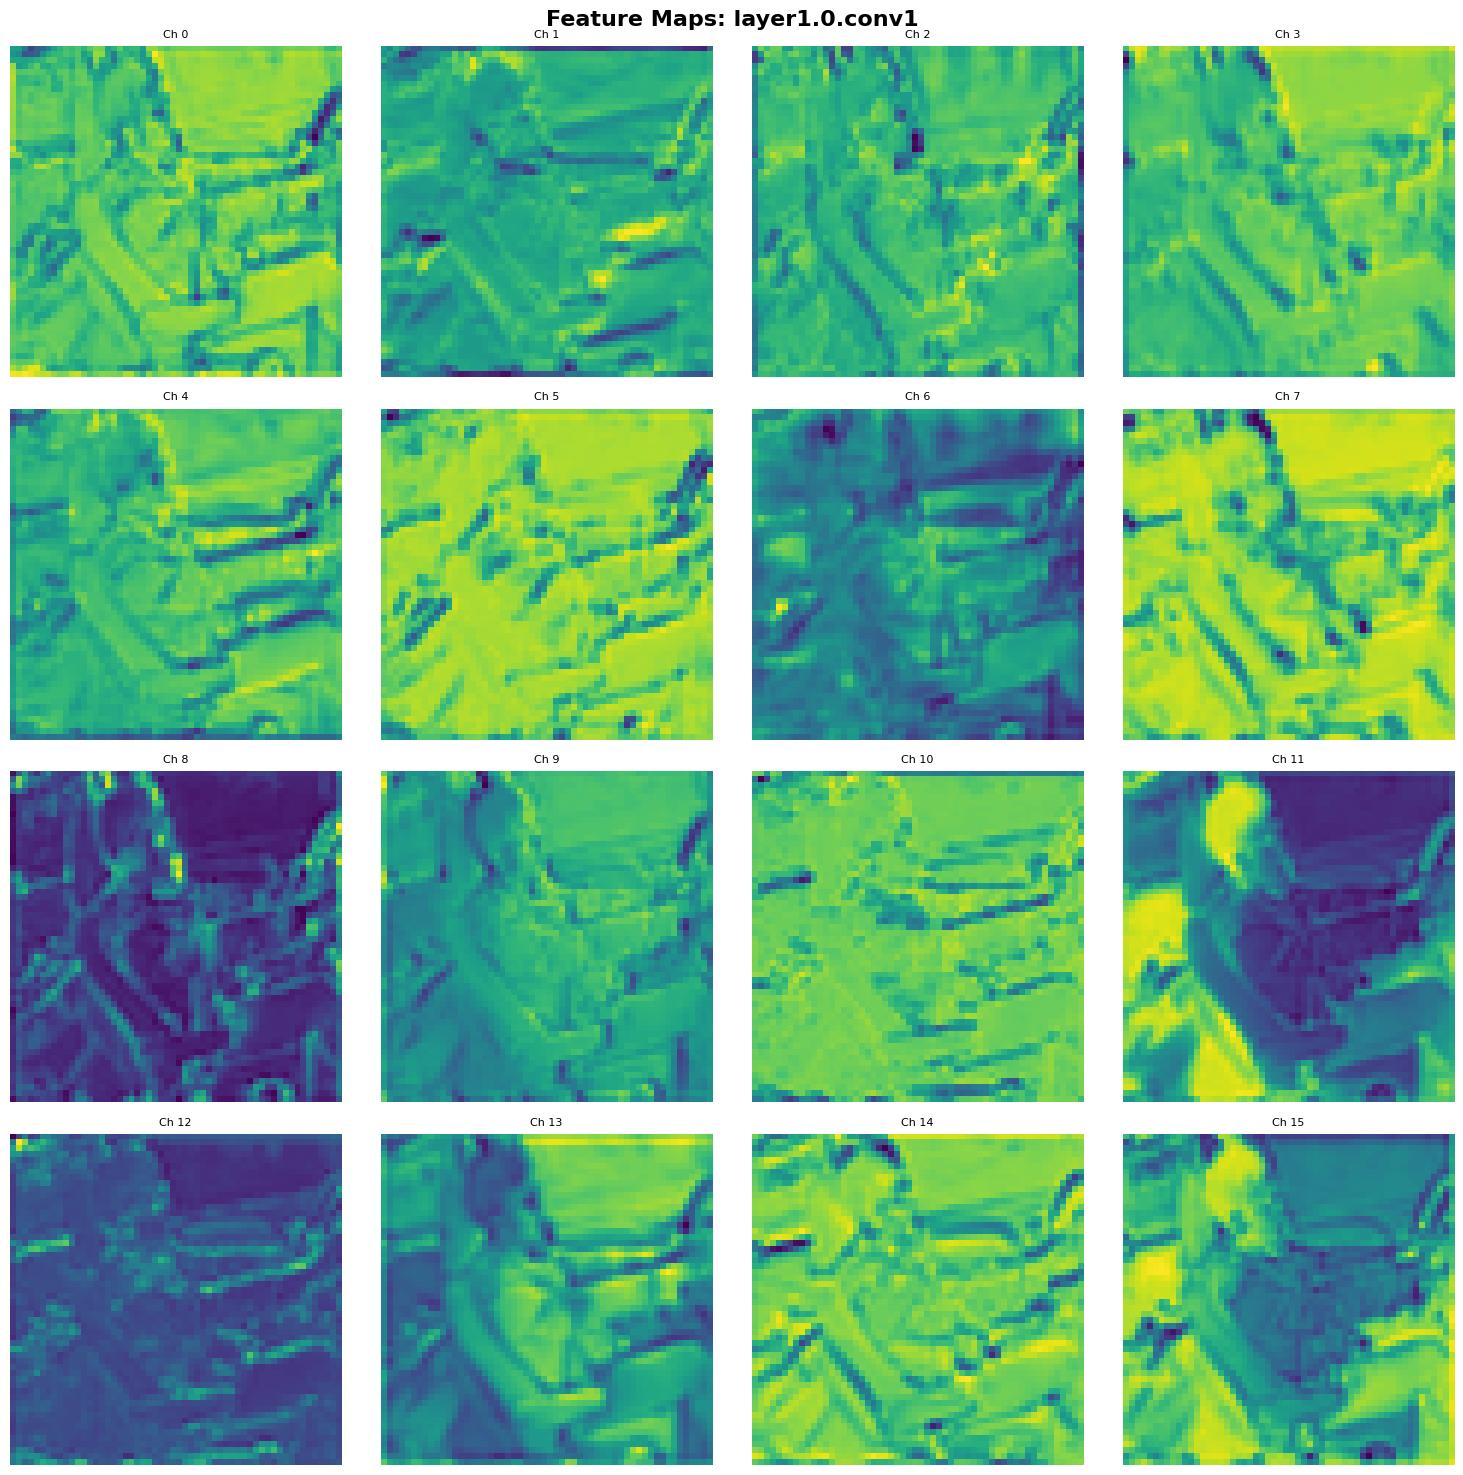

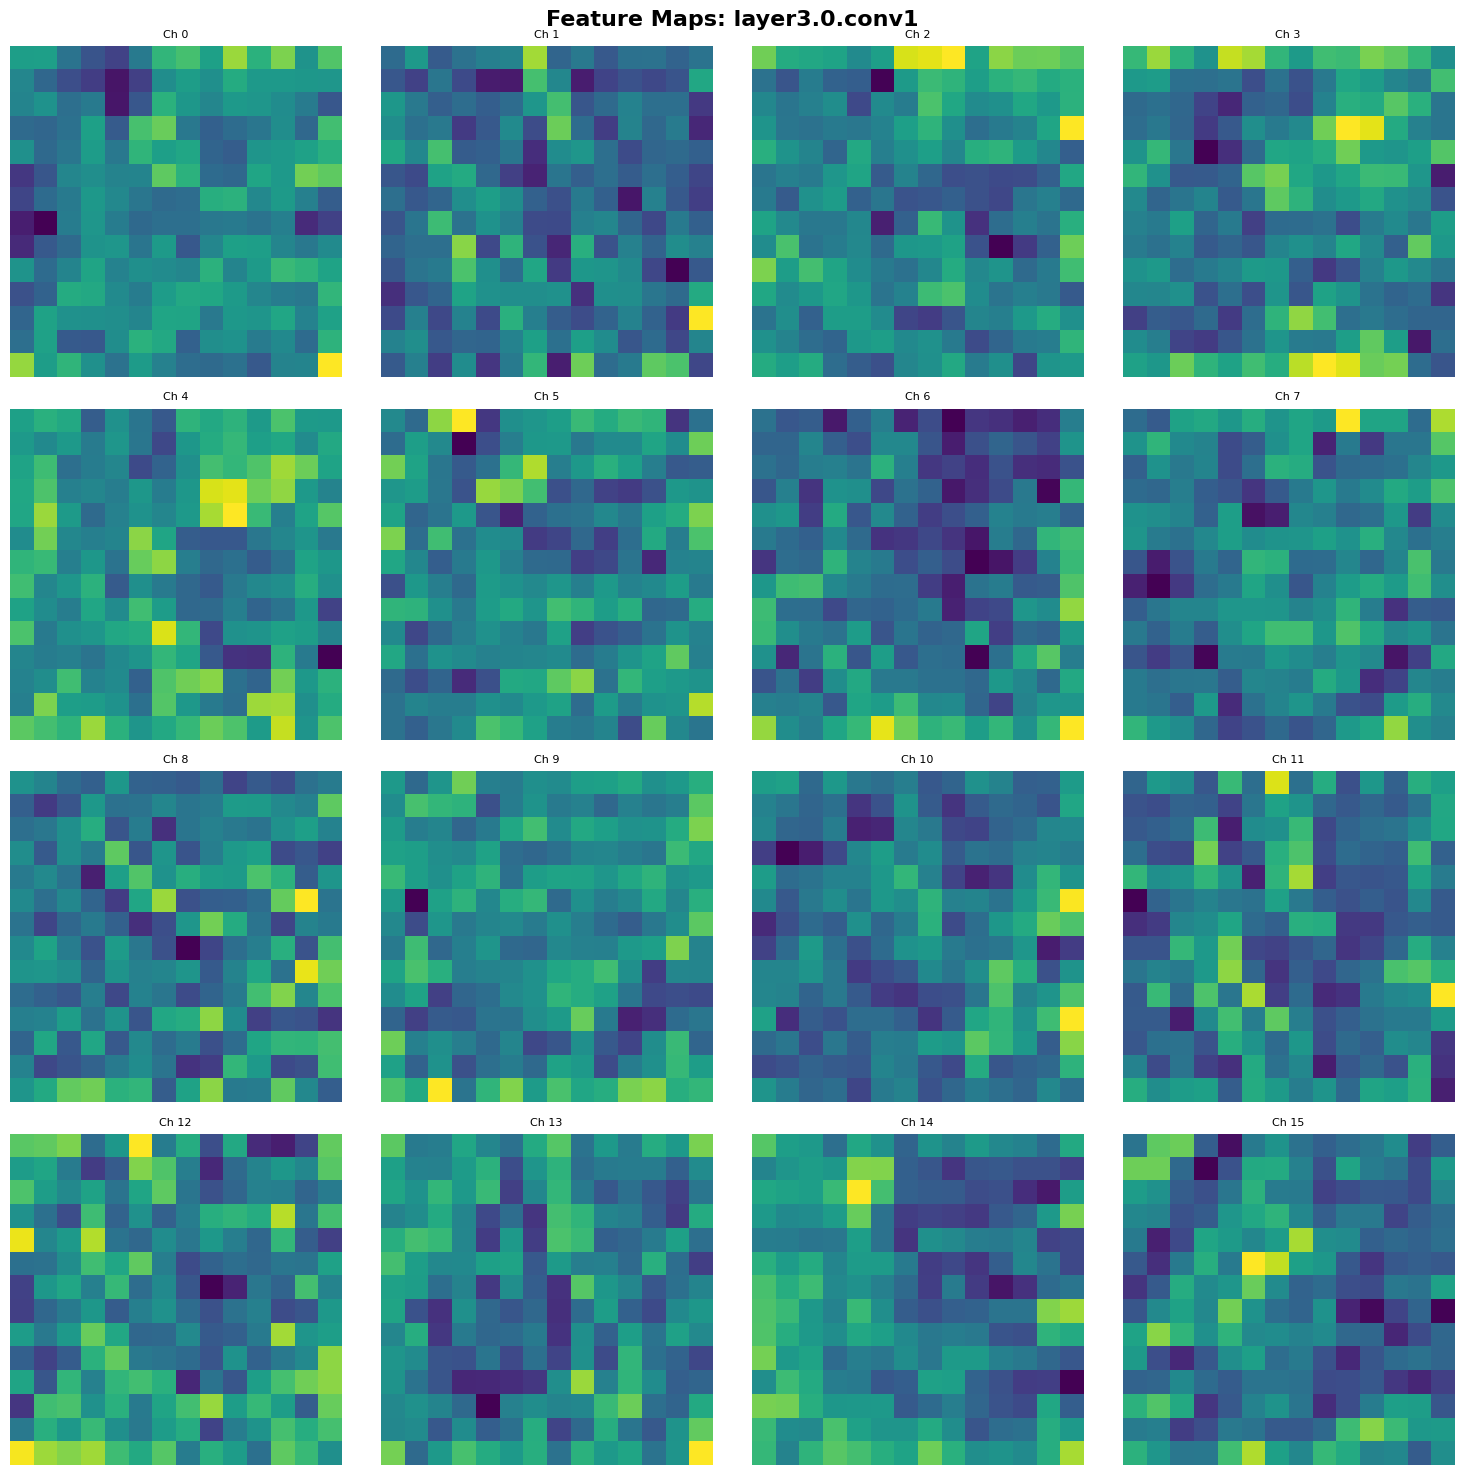

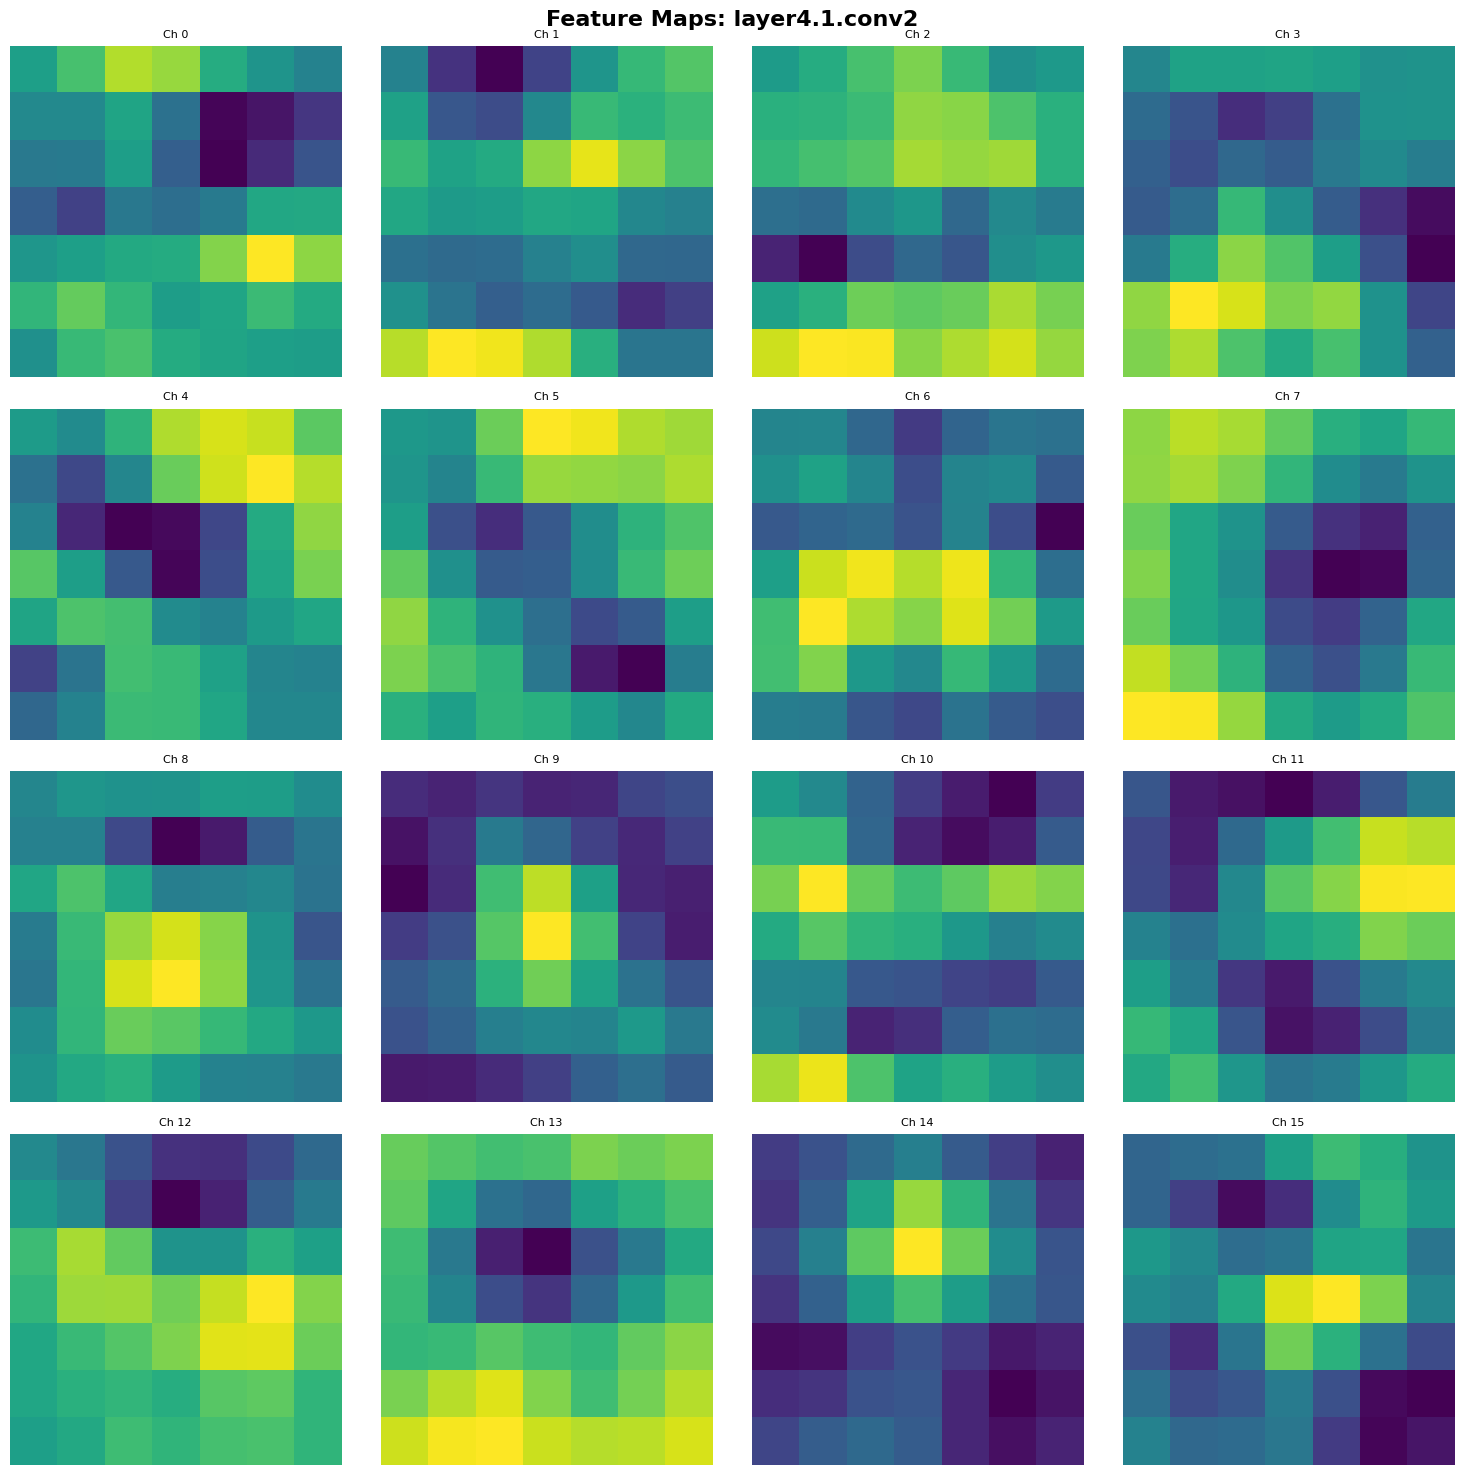


🧬 임베딩 추출 중...


임베딩 추출: 100%|██████████| 63/63 [00:08<00:00,  7.07it/s]


임베딩 shape: (4006, 512)

📊 t-SNE 계산 중...


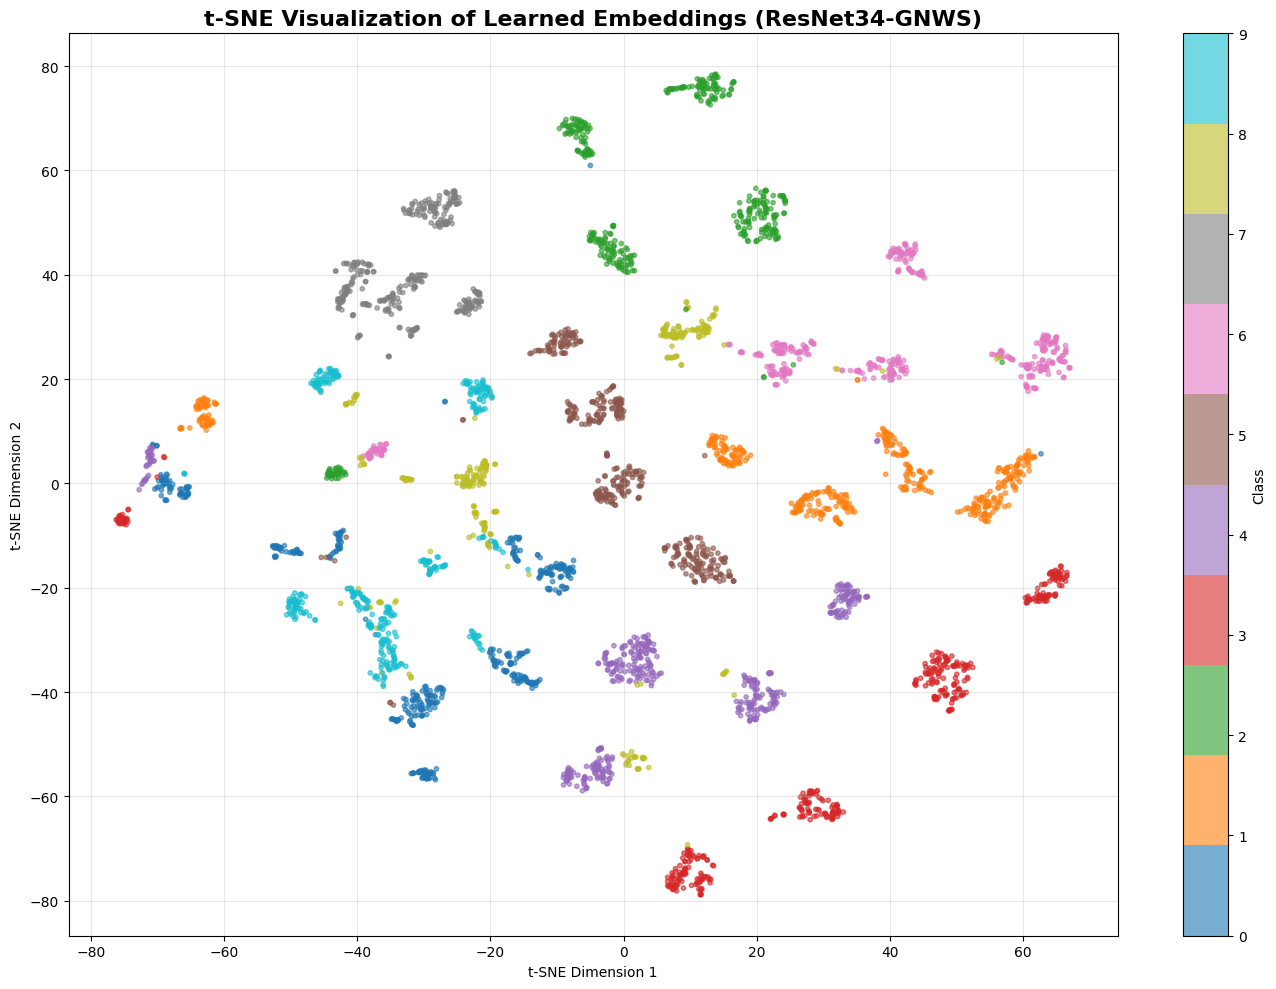

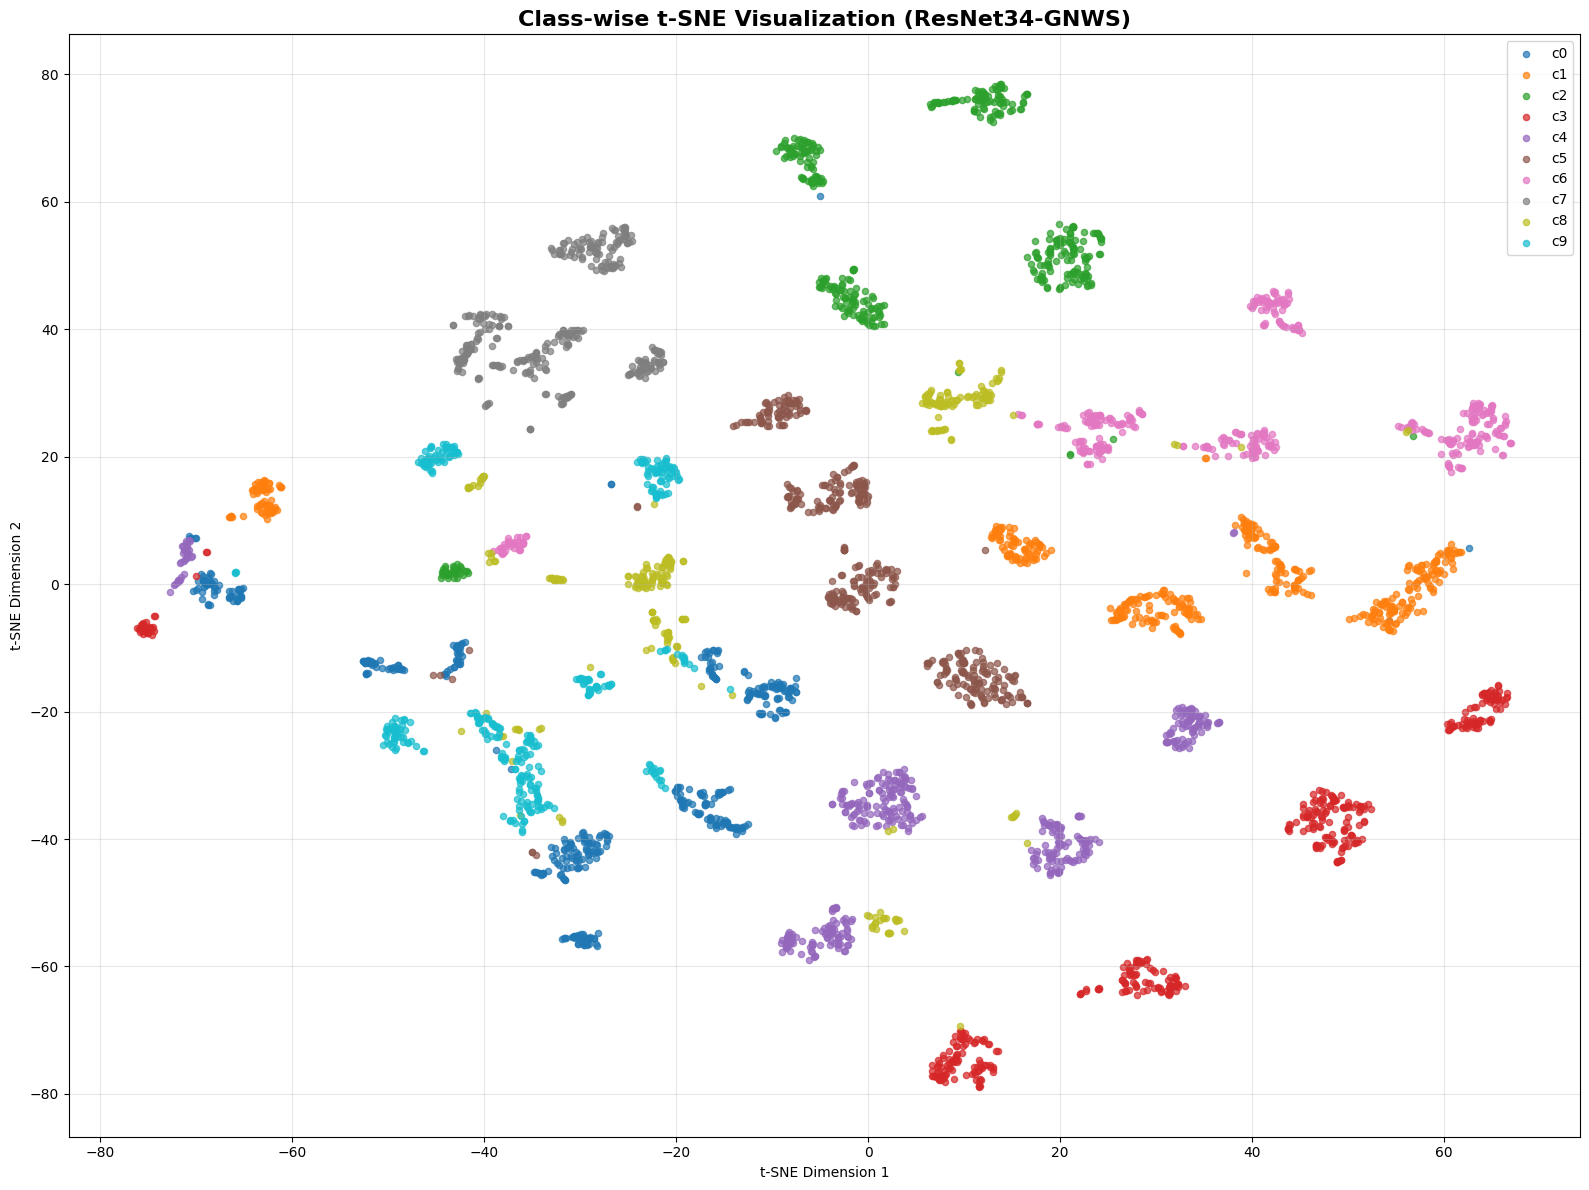

In [14]:
# =========================================
# 🔍 Feature Map & Embedding Visualization (수정본)
# =========================================
import os
os.makedirs("/content/plots", exist_ok=True)

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from sklearn.manifold import TSNE

# -------------------------------
# 1️⃣ Feature Map Extractor
# -------------------------------
class FeatureExtractor:
    """중간 레이어 Feature Map 추출"""
    def __init__(self, model, layer_names):
        self.model = model
        self.layer_names = layer_names
        self.features = {}
        for name, layer in model.named_modules():
            if name in layer_names:
                layer.register_forward_hook(self.save_feature(name))

    def save_feature(self, name):
        def hook(module, input, output):
            self.features[name] = output.detach()
        return hook

    def extract(self, x):
        self.features = {}
        _ = self.model(x)
        return self.features


def visualize_feature_maps(features, layer_name, max_channels=16):
    """Feature Map 시각화"""
    feature = features[layer_name][0]
    num_channels = min(feature.shape[0], max_channels)
    grid_size = int(np.ceil(np.sqrt(num_channels)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()
    for i in range(num_channels):
        fmap = feature[i].cpu().numpy()
        axes[i].imshow(fmap, cmap='viridis')
        axes[i].set_title(f'Ch {i}', fontsize=8)
        axes[i].axis('off')
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')
    plt.suptitle(f'Feature Maps: {layer_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# -------------------------------
# 2️⃣ Feature Map 시각화 실행
# -------------------------------
target_layers = ["layer1.0.conv1", "layer3.0.conv1", "layer4.1.conv2"]
sample_batch, _ = next(iter(val_loader))
sample_image = sample_batch[0:1].to(device)

extractor = FeatureExtractor(model, target_layers)
features = extractor.extract(sample_image)

for layer_name in target_layers:
    if layer_name in features:
        fig = visualize_feature_maps(features, layer_name, max_channels=16)
        plt.savefig(f'/content/plots/resnet34_gnws_featuremap_{layer_name.replace(".", "_")}.png', dpi=300)
        plt.show()

# -------------------------------
# 3️⃣ t-SNE 임베딩 시각화
# -------------------------------
def extract_embeddings(model, dataloader, device):
    """FC 직전 임베딩 추출"""
    model.eval()
    embeddings, labels = [], []
    features = []

    def hook(module, input, output):
        features.append(input[0].detach())

    # ResNet의 마지막 FC hook
    handle = model.fc.register_forward_hook(hook)
    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc='임베딩 추출'):
            images = images.to(device)
            _ = model(images)
            embeddings.append(features[-1].cpu().numpy())
            labels.extend(lbls.numpy())
            features.clear()
    handle.remove()

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    return embeddings, labels


print("\n" + "="*70)
print("🧬 임베딩 추출 중...")
print("="*70)

embeddings, labels = extract_embeddings(model, val_loader, device)
print(f"임베딩 shape: {embeddings.shape}")

# t-SNE 계산
print("\n📊 t-SNE 계산 중...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# t-SNE 전체 시각화
plt.figure(figsize=(14, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(scatter, label='Class', ticks=range(10))
plt.title('t-SNE Visualization of Learned Embeddings (ResNet34-GNWS)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/content/plots/resnet34_gnws_tsne_embeddings.png', dpi=300)
plt.show()

# -------------------------------
# 4️⃣ 클래스별 t-SNE 시각화
# -------------------------------
plt.figure(figsize=(16, 12))
for class_idx in range(10):
    mask = labels == class_idx
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        label=f'c{class_idx}',
        s=20,          # ✅ 밑줄 제거 (문법 오류 fix)
        alpha=0.7
    )
plt.legend()
plt.title('Class-wise t-SNE Visualization (ResNet34-GNWS)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/content/plots/resnet34_gnws_tsne_classwise.png', dpi=300)
plt.show()
